### Import Libraries

In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from pathlib import Path
from mne.io import read_info
from shared.data import StageFinder, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Short version using add_stages_to_dataset

Epoch data used:
<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 199, participant: 25)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         (participant, epochs) float64 nan 1.0 1.0 1.0 ... 2.0 nan 2.0
    resp         (participant, epochs) object '' 'resp_left' ... '' 'resp_left'
    rt           (participant, epochs) float64 nan 0.683 1.068 ... nan 1.02
    cue          (participant, epochs) object '' 'SP' 'AC' 'SP' ... 'SP' '' 'AC'
    movement     (participant, epochs) object '' 'stim_left' ... '' 'stim_right'
    trigger      (participant, epochs) object '' ... 'AC/stim_right/resp_left'
  * participant  (participant) object '0001' '0002' '0003' ... '0024' '0025'
Data variables:
    data         (participant, epochs, channels, samples) float64 n

/mnt/c/git/hsmm_mvpy/src/hsmm_mvpy/utils.py:533: UserWarning: Requested standardization of between participant variance yet no participant dimension is found in the data or only one participant is present. No standardization is done, set apply_standard to False to avoid this warning.
  warn('Requested standardization of between participant variance yet no participant dimension is found in the data or only one participant is present. No standardization is done, set apply_standard to False to avoid this warning.')


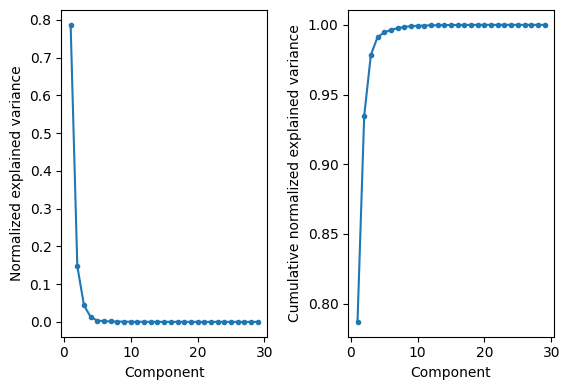

Fitting HMP model for AC condition
Estimating 4 events model with 100 starting point(s)
Parameters estimated for 4 events model
Labeling dataset for AC condition
Epochs used for current condition (if applicable):
<xarray.DataArray 'epochs' (epochs: 94)>
array([  2,   4,   6,   7,  11,  12,  15,  17,  19,  22,  23,  24,  28,  31,
        33,  35,  36,  37,  38,  43,  46,  47,  49,  50,  52,  53,  55,  57,
        58,  60,  63,  64,  65,  69,  71,  73,  75,  76,  78,  79,  80,  89,
        90,  91,  92,  93,  95, 101, 102, 106, 107, 108, 109, 112, 116, 120,
       121, 123, 124, 126, 128, 129, 133, 138, 139, 141, 143, 144, 148, 149,
       153, 155, 160, 165, 166, 167, 168, 169, 170, 172, 175, 177, 181, 182,
       183, 186, 187, 188, 189, 190, 191, 193, 198, 199])
Coordinates:
  * epochs   (epochs) int64 2 4 6 7 11 12 15 17 ... 188 189 190 191 193 198 199
Processing participant 0001
Participant: 0, Epoch: 2, Sample range: slice(28, 35, None), Reaction time sample: 198
Participant: 0, Ep

In [13]:
# Amount of cores to use in multiprocessing
cpus = 12

epoched_data_path = Path("data/sat1/data.nc")
output_path = Path("data/sat1/stage_data.nc")
conditions = ["AC", "SP"]
# labels = {"AC": SAT1_STAGES_ACCURACY[:-1], "SP": SAT1_STAGES_SPEED[:-1]}
labels = {"AC": SAT1_STAGES_ACCURACY, "SP": SAT1_STAGES_SPEED}

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 100},
    verbose=True,
)
stage_data = stage_finder.add_stages_to_dataset()

# Use fit(), letting the model decide on an amount of events
# stage_data = add_stages_to_dataset(
#     epoched_data_path, output_path, labels, conditions=conditions, cpus=cpus
# )

stage_data.to_netcdf(output_path)

In [78]:
stage_data.sel(participant="0001", epochs=0).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', ''], dtype=object)
Coordinates:
    epochs       int64 0
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 nan
    resp         object ''
    rt           float64 nan
    cue          object ''
    movement     object ''
    trigger      object ''
    participant  <U4 '0001'

### Manual version

In [8]:
# Amount of cores to use in multiprocessing
cpus = 12

# Load complete SAT1 dataset
eeg_data = xr.load_dataset("data/sat1/data.nc")

# Load x and y positions of electrodes
positions_path = Path("data/sat1/preprocessed/processed_0001_epo.fif")
positions = read_info(Path("data/sat1/preprocessed/processed_0001_epo.fif"))

output_path = Path("data/sat1/stage_data.nc")

In [3]:
eeg_data = eeg_data.sel(participant=["0021", "0022", "0023", "0024"])

In [28]:
eeg_data

<xarray.DataArray 'data' (participant: 1, samples: 199)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan]])
Coordinates:
    epochs       int64 0
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         (participant) float64 nan
    resp         (participant) object ''
    rt           (participant) float64 nan
    cue          (participant) object ''
    movement     (participant) object ''
    trigger      (participant) object ''
  * participant  (participant) object '0001'

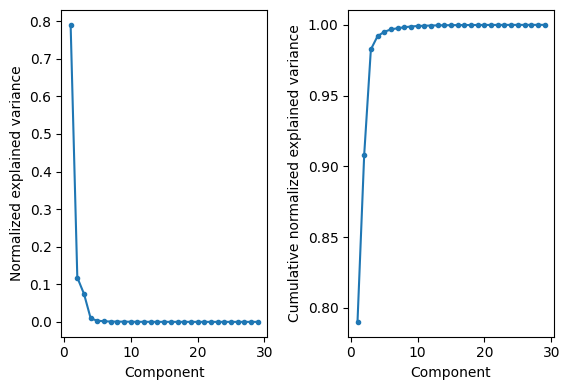

In [9]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data)

### Initialize models

Number of potential magnitudes: 81
Because of decimation 27 will be estimated.


100%|██████████| 27/27 [02:54<00:00,  6.48s/it]


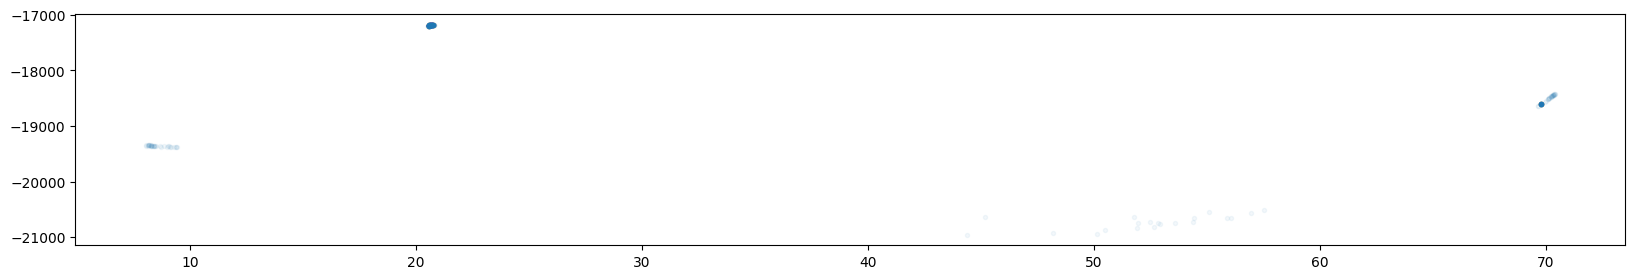

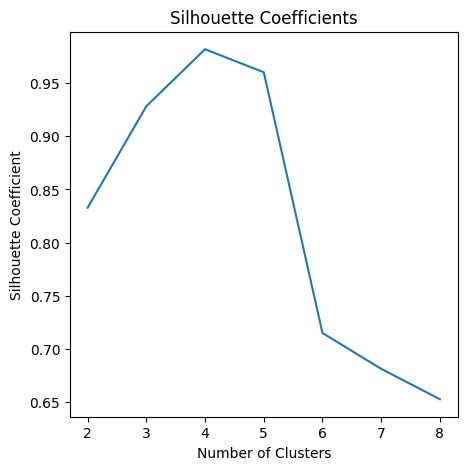

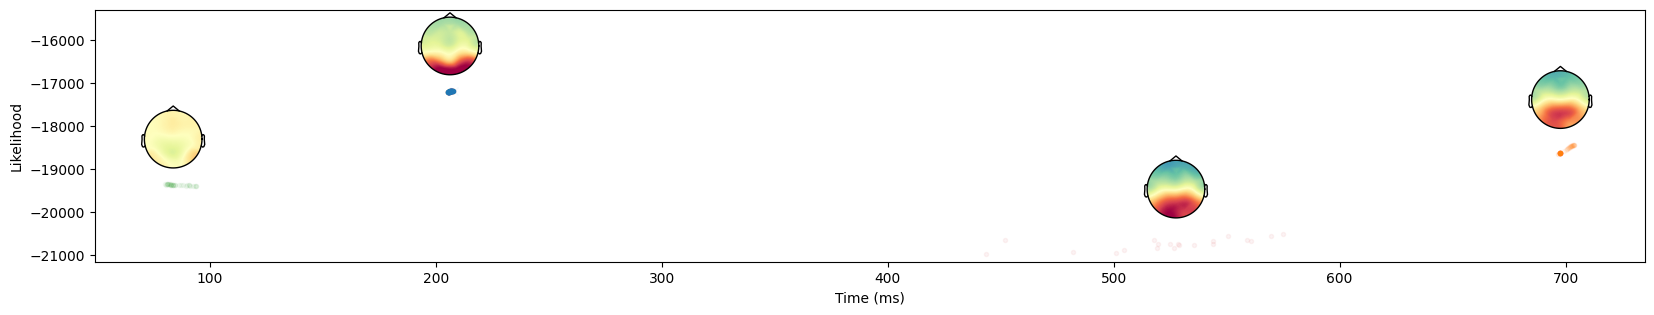

Estimating 4 events model
Parameters estimated for 4 events model


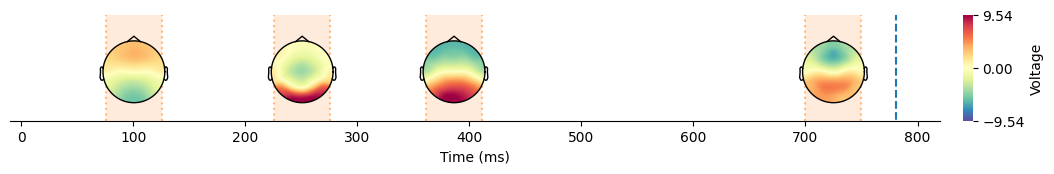

In [10]:
# Alternative method of fitting without supplying nr of events, use to explore new datasets
subset = eeg_data.where(eeg_data["cue"].str.contains("AC"))

init_accuracy = hmp.models.hmp(
    hmp_data,
    subset,
    cpus=cpus,
    sfreq=eeg_data.sfreq,
    estimate_magnitudes=True,
)
# calc estimates
lkhs, mags, channels, times = init_accuracy.sliding_event_mags(
    subset, step=5, decimate_grid=3, cpu=cpus, plot=True, min_iteration=10
)

# cluster in time, lkh, and mags
mags_cl, pars_cl = hmp.clusters.cluster_events(
    init_accuracy,
    lkhs,
    mags,
    channels,
    times,
    method="time_x_lkh_x_mags",
    max_clust=8,
    p_outlier=0.05,
    info=positions,
    calc_outliers=True,
)

# fit final model
best_estimate = init_accuracy.fit_single(
    mags_cl.shape[0], magnitudes=mags_cl, parameters=pars_cl
)
hmp.visu.plot_topo_timecourse(
    eeg_data,
    best_estimate,
    positions,
    init_accuracy,
    magnify=1,
    sensors=False,
    time_step=1000 / init_accuracy.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
)

In [6]:
hmp_accuracy_data = hmp.utils.condition_selection(
    hmp_data, eeg_data, "AC", variable="cue"
)
model_accuracy = hmp.models.hmp(
    hmp_accuracy_data, cpus=cpus, sfreq=eeg_data.sfreq, estimate_magnitudes=True
)


hmp_speed_data = hmp.utils.condition_selection(hmp_data, eeg_data, "SP", variable="cue")
model_speed = hmp.models.hmp(
    hmp_speed_data, cpus=cpus, sfreq=eeg_data.sfreq, estimate_magnitudes=True
)

#### Regular fitting

In [29]:
# Let model find stage transitions
fit_accuracy = model_accuracy.fit(grid_points=10, fix_iter=False)

  0%|          | 0/89 [00:00<?, ?it/s]

Transition event 1 found around sample 8
Transition event 2 found around sample 26
Transition event 3 found around sample 52
Transition event 4 found around sample 59
Transition event 5 found around sample 62
Transition event 6 found around sample 83
Estimating 6 events model
Parameters estimated for 6 events model


In [25]:
fit_speed = model_speed.fit(grid_points=25, fix_iter=False)

  0%|          | 0/51 [00:00<?, ?it/s]

Transition event 1 found around sample 8
Transition event 2 found around sample 25
Transition event 3 found around sample 45
Estimating 3 events model
Parameters estimated for 3 events model


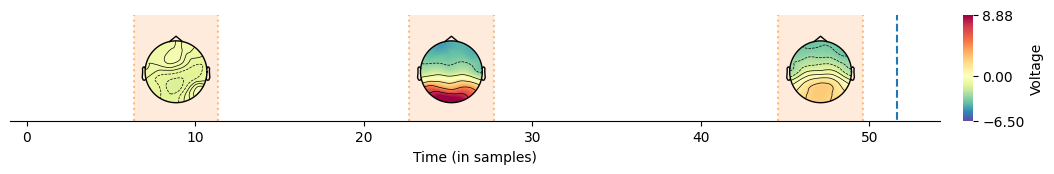

In [27]:
hmp.visu.plot_topo_timecourse(
    eeg_data,
    fit_speed,
    positions,
    model_speed,
    vmin=-6.5,
    times_to_display=np.mean(model_speed.ends - model_speed.starts),
)

In [7]:
# Tell model amount of events
fit_accuracy = model_accuracy.fit_single(4, starting_points=100)
fit_speed = model_speed.fit_single(3, starting_points=100)

Estimating 4 events model with 100 starting point(s)
Parameters estimated for 4 events model
Estimating 3 events model with 100 starting point(s)
Parameters estimated for 3 events model


In [41]:
eeg_data.where(eeg_data.cue == "AC", drop=True).epochs

<xarray.DataArray 'epochs' (epochs: 94)>
array([  2,   4,   6,   7,  11,  12,  15,  17,  19,  22,  23,  24,  28,  31,
        33,  35,  36,  37,  38,  43,  46,  47,  49,  50,  52,  53,  55,  57,
        58,  60,  63,  64,  65,  69,  71,  73,  75,  76,  78,  79,  80,  89,
        90,  91,  92,  93,  95, 101, 102, 106, 107, 108, 109, 112, 116, 120,
       121, 123, 124, 126, 128, 129, 133, 138, 139, 141, 143, 144, 148, 149,
       153, 155, 160, 165, 166, 167, 168, 169, 170, 172, 175, 177, 181, 182,
       183, 186, 187, 188, 189, 190, 191, 193, 198, 199])
Coordinates:
  * epochs   (epochs) int64 2 4 6 7 11 12 15 17 ... 188 189 190 191 193 198 199

In [44]:
eeg_data.data.where(eeg_data["cue"] == "SP", drop=True).epochs[0]

<xarray.DataArray 'epochs' ()>
array(1)
Coordinates:
    epochs   int64 1

In [22]:
fit_accuracy.eventprobs.idxmax(dim="samples")

<xarray.DataArray 'samples' (trial_x_participant: 94, event: 4)>
array([[  3.,  29.,  41.,  55.],
       [  2.,  25.,  42.,  45.],
       [  4.,  28.,  38.,  53.],
       [  5.,  22.,  73.,  82.],
       [  4.,  21.,  42.,  46.],
       [  3.,  21.,  44.,  56.],
       [  5.,  26.,  59.,  69.],
       [  3.,  23.,  43.,  55.],
       [  6.,  28.,  45.,  58.],
       [  4.,  26.,  34.,  50.],
       [  4.,  23.,  40.,  42.],
       [  3.,  24.,  42.,  47.],
       [  3.,  19.,  38.,  49.],
       [  2.,  21.,  37.,  46.],
       [  5.,  31.,  46.,  50.],
       [  4.,  22.,  42.,  51.],
       [  1.,  27.,  33.,  55.],
       [  3.,  24.,  37.,  52.],
       [  6.,  33.,  49.,  58.],
       [  5.,  28.,  51.,  62.],
...
       [  7.,  20.,  65.,  66.],
       [  3.,  13.,  32.,  39.],
       [  4.,  25.,  62.,  64.],
       [  3.,  46.,  87.,  92.],
       [  2.,  22.,  44.,  49.],
       [  4.,  31.,  82.,  85.],
       [  2.,  57.,  95., 100.],
       [  5.,  24.,  49.,  62.],
       [  2.,  30.,  45.,  49.],
       [ 10.,  25.,  55.,  67.],
       [  7.,  21.,  40.,  46.],
       [  2.,  27.,  37.,  43.],
       [  1.,  38.,  45.,  56.],
       [  7.,  26.,  49.,  64.],
       [  6.,  23.,  33.,  44.],
       [  5.,  26.,  54.,  67.],
       [  2.,  31.,  39.,  52.],
       [  2.,   8.,  17.,  31.],
       [  2.,  29.,  57.,  68.],
       [  3.,  34.,  49.,  67.]])
Coordinates:
  * event                (event) int64 0 1 2 3
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object '0001' '0001' ... '0001'
  * trials               (trial_x_participant) int64 0 1 2 3 4 ... 90 91 92 93

In [9]:
fit_accuracy.trial_x_participant

<xarray.DataArray 'trial_x_participant' (trial_x_participant: 94)>
array([('0001', 0), ('0001', 1), ('0001', 2), ('0001', 3), ('0001', 4),
       ('0001', 5), ('0001', 6), ('0001', 7), ('0001', 8), ('0001', 9),
       ('0001', 10), ('0001', 11), ('0001', 12), ('0001', 13), ('0001', 14),
       ('0001', 15), ('0001', 16), ('0001', 17), ('0001', 18), ('0001', 19),
       ('0001', 20), ('0001', 21), ('0001', 22), ('0001', 23), ('0001', 24),
       ('0001', 25), ('0001', 26), ('0001', 27), ('0001', 28), ('0001', 29),
       ('0001', 30), ('0001', 31), ('0001', 32), ('0001', 33), ('0001', 34),
       ('0001', 35), ('0001', 36), ('0001', 37), ('0001', 38), ('0001', 39),
       ('0001', 40), ('0001', 41), ('0001', 42), ('0001', 43), ('0001', 44),
       ('0001', 45), ('0001', 46), ('0001', 47), ('0001', 48), ('0001', 49),
       ('0001', 50), ('0001', 51), ('0001', 52), ('0001', 53), ('0001', 54),
       ('0001', 55), ('0001', 56), ('0001', 57), ('0001', 58), ('0001', 59),
       ('0001', 60), ('0001', 61), ('0001', 62), ('0001', 63), ('0001', 64),
       ('0001', 65), ('0001', 66), ('0001', 67), ('0001', 68), ('0001', 69),
       ('0001', 70), ('0001', 71), ('0001', 72), ('0001', 73), ('0001', 74),
       ('0001', 75), ('0001', 76), ('0001', 77), ('0001', 78), ('0001', 79),
       ('0001', 80), ('0001', 81), ('0001', 82), ('0001', 83), ('0001', 84),
       ('0001', 85), ('0001', 86), ('0001', 87), ('0001', 88), ('0001', 89),
       ('0001', 90), ('0001', 91), ('0001', 92), ('0001', 93)], dtype=object)
Coordinates:
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object '0001' '0001' ... '0001'
  * trials               (trial_x_participant) int64 0 1 2 3 4 ... 90 91 92 93

In [10]:
fit_speed.trial_x_participant

<xarray.DataArray 'trial_x_participant' (trial_x_participant: 90)>
array([('0001', 0), ('0001', 1), ('0001', 2), ('0001', 3), ('0001', 4),
       ('0001', 5), ('0001', 6), ('0001', 7), ('0001', 8), ('0001', 9),
       ('0001', 10), ('0001', 11), ('0001', 12), ('0001', 13), ('0001', 14),
       ('0001', 15), ('0001', 16), ('0001', 17), ('0001', 18), ('0001', 19),
       ('0001', 20), ('0001', 21), ('0001', 22), ('0001', 23), ('0001', 24),
       ('0001', 25), ('0001', 26), ('0001', 27), ('0001', 28), ('0001', 29),
       ('0001', 30), ('0001', 31), ('0001', 32), ('0001', 33), ('0001', 34),
       ('0001', 35), ('0001', 36), ('0001', 37), ('0001', 38), ('0001', 39),
       ('0001', 40), ('0001', 41), ('0001', 42), ('0001', 43), ('0001', 44),
       ('0001', 45), ('0001', 46), ('0001', 47), ('0001', 48), ('0001', 49),
       ('0001', 50), ('0001', 51), ('0001', 52), ('0001', 53), ('0001', 54),
       ('0001', 55), ('0001', 56), ('0001', 57), ('0001', 58), ('0001', 59),
       ('0001', 60), ('0001', 61), ('0001', 62), ('0001', 63), ('0001', 64),
       ('0001', 65), ('0001', 66), ('0001', 67), ('0001', 68), ('0001', 69),
       ('0001', 70), ('0001', 71), ('0001', 72), ('0001', 73), ('0001', 74),
       ('0001', 75), ('0001', 76), ('0001', 77), ('0001', 78), ('0001', 79),
       ('0001', 80), ('0001', 81), ('0001', 82), ('0001', 83), ('0001', 84),
       ('0001', 85), ('0001', 86), ('0001', 87), ('0001', 88), ('0001', 89)],
      dtype=object)
Coordinates:
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object '0001' '0001' ... '0001'
  * trials               (trial_x_participant) int64 0 1 2 3 4 ... 86 87 88 89

In [6]:
acc_labels = label_model(fit_accuracy, eeg_data, SAT1_STAGES_ACCURACY)
sp_labels = label_model(fit_speed, eeg_data, SAT1_STAGES_SPEED)

Processing participant 0001
Processing participant 0002
Processing participant 0003
Processing participant 0004
Processing participant 0005
Processing participant 0006
Processing participant 0007
Processing participant 0008
Processing participant 0009
Processing participant 0010
Processing participant 0011
Processing participant 0012
Processing participant 0013
Processing participant 0014
Processing participant 0015
Processing participant 0016
Processing participant 0017
Processing participant 0018
Processing participant 0019
Processing participant 0020
Processing participant 0021
Processing participant 0022
Processing participant 0023
Processing participant 0024
Processing participant 0025
Processing participant 0001
Processing participant 0002
Processing participant 0003
Processing participant 0004
Processing participant 0005
Processing participant 0006
Processing participant 0007
Processing participant 0008
Processing participant 0009
Processing participant 0010
Processing participa

In [7]:
# Merge AC and SP condition labels (an epoch is either AC or SP so these are sets without common members)
merged = np.where(acc_labels == np.nan, sp_labels, acc_labels)
# Add stage info to eeg_data Dataset and save
stage_data = eeg_data.assign_coords(
    labels=(["participant", "epochs", "samples"], merged)
)
stage_data.to_netcdf(output_path)

# Debugging

In [10]:
# Check dataset size in MB
print(eeg_data.nbytes / (1024**2))
print(stage_data.nbytes / (1024**2))

227.9697723388672
235.56101989746094


In [33]:
stage_data.sel(participant="0021", epochs=1, samples=slice(1, 150)).labels

<xarray.DataArray 'labels' (samples: 150)>
array([nan, nan, nan, nan, 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan], dtype=object)
Coordinates:
    epochs       int64 1
  * samples      (samples) int64 1 2 3 4 5 6 7 8 ... 144 145 146 147 148 149 150
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.388
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'
    labels       (samples) object nan nan nan nan 'encoding' ... nan nan nan nan

In [98]:
int(eeg_data.sel(participant="0021", epochs=1).isnull().argmax("samples").data[0])

139

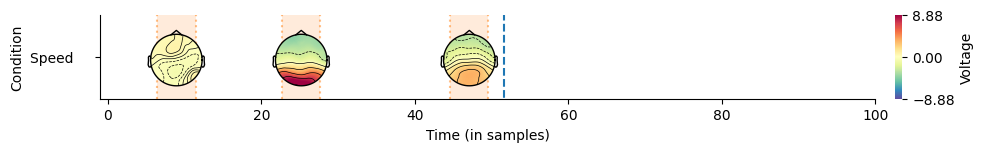

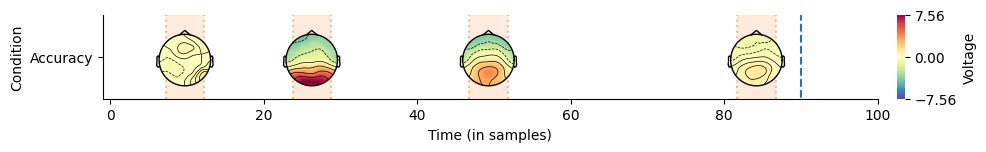

In [32]:
for condition in zip(
    [fit_speed, fit_accuracy],
    [model_speed, model_accuracy],
    [hmp_speed_data, hmp_accuracy_data],
    ["Speed    ", "Accuracy"],
):
    hmp.visu.plot_topo_timecourse(
        eeg_data,
        condition[0],
        positions,
        condition[1],
        times_to_display=np.mean(condition[1].ends - condition[1].starts),
        max_time=100,
        figsize=(10, 1),
        ylabels={"Condition": [condition[3]]},
    )